In [1]:
## Import common python libraries
import numpy as np
import pandas as pd

# For optimization
from scipy import optimize as opt
from utils import sigmoid,sigmoid_gradient,save_fig

# Matplotlib for plotting figures
import matplotlib as mpl
import matplotlib.pyplot as plt

seed = 1

%matplotlib inline

In [2]:
# load the preprocessed iris dataset
dataset = pd.read_csv('datasets/iris_process_multi_class.data',
                      delimiter=',',
                      header=None, 
                      names=['sepal length', 'sepal width', 'petal length', 'petal width','class'])

print('\nNumber of records:',len(dataset))
print('\nclass domain:', dataset['class'].unique())
print('\n\n',dataset.head())


Number of records: 150

class domain: [0 1 2]


    sepal length  sepal width  petal length  petal width  class
0           5.1          3.5           1.4          0.2      0
1           4.9          3.0           1.4          0.2      0
2           4.7          3.2           1.3          0.2      0
3           4.6          3.1           1.5          0.2      0
4           5.0          3.6           1.4          0.2      0


In [3]:
X = pd.DataFrame(dataset,columns=['petal length','petal width']).values
y = dataset['class'].values.reshape(-1,1)

# Hyperparameter, regularization term, Lambda value
Lambda = 1.00

In [4]:
def plot_dataset(X,y):
    plt.scatter(X[y == 0, 0],X[y == 0, 1],
                s=50, c='lightgreen',
                marker='o', edgecolor='black',label='class 1')
    plt.scatter(X[y == 1, 0],X[y == 1, 1],
                s=50, c='blue',
                marker='v', edgecolor='black',
                label='class 2')
    plt.scatter(X[y == 2, 0],X[y == 2, 1],
                s=50, c='red',
                marker='s', edgecolor='black',
                label='class 3')
    plt.tight_layout()
    plt.xlabel("petal length", fontsize=14)
    plt.ylabel("petal width", fontsize=14)

Saving figure multi_class_training_data


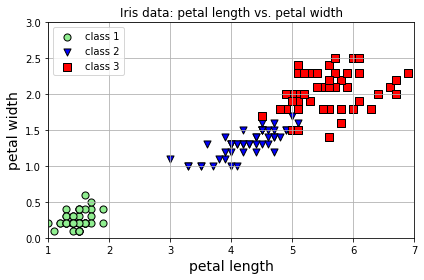

In [5]:
plt.figure(1)
plt.title('Iris data: petal length vs. petal width')
plot_dataset(X,y.ravel())
plt.grid(True)
plt.axis([1,7,0,3])
plt.legend()
save_fig("multi_class_training_data")
plt.show()

In [6]:
def layer_sizes(X,y):
    input_layer = X.shape[1]
    hidden_layer = 10
    output_layer = len(np.unique(y))
    return input_layer, hidden_layer, output_layer

In [7]:
def initialize_parameters(layer_in,layer_out):
    np.random.seed(seed)
    random_epsilon = np.sqrt(6) / np.sqrt(layer_in+layer_out)
    return (np.random.random((layer_out, layer_in + 1)) *(2*random_epsilon)) - random_epsilon

In [8]:
def feed_forward(X, theta):
    # -------------------------------------------------------------
    # Retrieving parameters
    # -------------------------------------------------------------
    W1 = theta[:(input_layer+1)*hidden_layer].reshape((hidden_layer,(input_layer+1)))
    W2 = theta[(input_layer+1)*hidden_layer:].reshape((output_layer,(hidden_layer+1)))
        
    # -------------------------------------------------------------
    # The Forward Propagation Implementation
    # -------------------------------------------------------------
    A1 = np.insert(X,0,1,axis=1)       
    Z2 = np.dot(A1,W1.T)
    A2 = np.insert(sigmoid(Z2),0,1,axis=1)
    Z3 = np.dot(A2,W2.T)
    A3 = sigmoid(Z3)
    
    # -------------------------------------------------------------
    # Saving activations to dictionary
    # -------------------------------------------------------------
    cache = {"A1":A1,
             "Z2":Z2, 
             "A2":A2, 
             "Z3":Z3,
             "A3":A3}

    return A3, cache

In [9]:
def nn_cost_function(A3,y,theta,Lambda):
    # --------------------------
    # Retrieving parameters
    # --------------------------
    W1 = theta[:(input_layer+1)*hidden_layer].reshape((hidden_layer,(input_layer+1)))
    W2 = theta[(input_layer+1)*hidden_layer:].reshape((output_layer,(hidden_layer+1)))
    
    # -------------------------------------------------------------
    # Mapping vector y into a binary vector of 1's and 0's 
    # -------------------------------------------------------------
    y_matrix = np.zeros((len(y), len(np.unique(y))))
    for i in range(len(y)):
        y_matrix[i, y[i] - 1] = 1
    
    # --------------------------
    # cross-entropy loss function
    # --------------------------
    reg_term = (Lambda/(2*len(y))) * (np.sum(np.sum(np.square(W1[:,1:]))) + np.sum(np.sum(np.square(W2[:,1:])))) 
    return ((1/len(y) * np.sum(np.sum((np.multiply(-y_matrix,np.log(A3))- np.multiply((1-y_matrix),np.log(1-A3)))))) + reg_term)

In [10]:
def backward_propagation(theta,cache,y,Lambda):
    # --------------------------
    # Retrieving parameters
    # --------------------------
    W1 = theta[:(input_layer+1)*hidden_layer].reshape((hidden_layer,(input_layer+1)))
    W2 = theta[(input_layer+1)*hidden_layer:].reshape((output_layer,(hidden_layer+1)))
    
    # -------------------------------------------------------------
    # Retrieving cached activations
    # -------------------------------------------------------------
    A1 = cache["A1"]
    Z2 = cache["Z2"]
    A2 = cache["A2"]
    Z3 = cache["Z3"]
    A3 = cache["A3"]
    
    # -------------------------------------------------------------
    # Mapping vector y into a binary vector of 1's and 0's 
    # -------------------------------------------------------------
    y_matrix = np.zeros((len(y), len(np.unique(y))))
    for i in range(len(y)):
        y_matrix[i, y[i] - 1] = 1
    
    # -------------------------------------------------------------
    # The Backward Propagation Implementation
    # -------------------------------------------------------------
    d3 = (A3 - y_matrix)
    u  = sigmoid(Z2)
    d2 = (Z3 - y).dot(W2[:,1:]) * sigmoid_gradient(u)
    D1 = d2.T.dot(A1) / len(y)
    D2 = d3.T.dot(A2) / len(y)
    if Lambda!=0:
        D1[:,1:] += (Lambda/len(y) * W1[:,1:])
        D2[:,1:] += (Lambda/len(y) * W2[:,1:])

    # Roll grads D1 and D2 back into 1D array
    grads = np.concatenate((D1.reshape(((input_layer+1)*hidden_layer)),
                            D2.reshape(((hidden_layer+1)*output_layer))))
    return grads

In [11]:
# Setting network structure
input_layer,hidden_layer, output_layer = layer_sizes(X,y)
    
# Initialize and combine thetas
theta_init = np.concatenate((initialize_parameters(input_layer,hidden_layer).reshape(((input_layer+1)*hidden_layer)),
                             initialize_parameters(hidden_layer,output_layer).reshape(((hidden_layer+1)*output_layer))))

In [12]:
def nn_model(theta,X,y,Lambda):
 
    # Forward propagation
    A3, cache = feed_forward(X, theta)

    # cross-entropy loss function
    cost = nn_cost_function(A3,y,theta,Lambda)
    
    # Backpropagation
    grads = backward_propagation(theta,cache,y,Lambda) 

    return cost, grads

In [13]:
def predict(X, theta):
    A3 = feed_forward(X,theta)[0]
    return np.argmax(A3, axis=1)

In [14]:
def cost_function(theta,X,y,Lambda):
    return nn_model(theta,X,y,Lambda)[0]

In [15]:
print("\nInitial cost:",cost_function(theta_init,X,y,Lambda))


Initial cost: 1.9462448710044782


In [16]:
def gradient_function(theta,X,y,Lambda):
    return nn_model(theta,X,y,Lambda)[1]

In [17]:
def fit(theta_init,X,y,Lambda):
    obj_func = lambda t: cost_function(t,X,y,Lambda);
    result = opt.minimize(obj_func, x0=theta_init, method='BFGS')
    return result.x, result.fun

In [18]:
theta, error = fit(theta_init,X,y,Lambda);
print("Error (at minimum point): %f" %(error))

Error (at minimum point): 0.587708


In [19]:
prediction = predict(X, theta)
print('\nUnique elements in Prediction: %s'%(np.unique(prediction)))


Unique elements in Prediction: [0 1 2]


In [20]:
def nn_decision_boundary(X,theta):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = predict(np.c_[xx.ravel(), yy.ravel()],theta)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)

Saving figure multi_class_decision_boundary


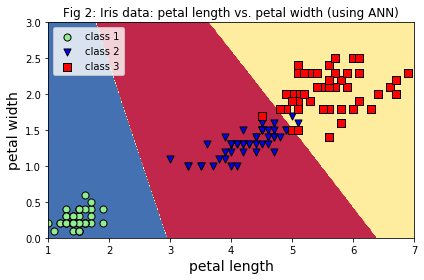

In [21]:
plt.figure(2)
plt.title("Fig 2: Iris data: petal length vs. petal width (using ANN)")
nn_decision_boundary(X,theta)
plot_dataset(X,y.ravel())
plt.axis([1,7,0,3])
plt.legend()
save_fig("multi_class_decision_boundary")
plt.show()